[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GP248CME215/Curve-fitting/blob/main/Curve_fitting_1D.ipynb)





In [ ]:
##############################################################################################################
# RUN THIS CODE BLOCK FIRST, it will load dependencies / install them if your system does not already have them.
##############################################################################################################

# tensorflow
try:
    # Try to import TensorFlow
    import tensorflow as tf
    print(f"TensorFlow is already installed. Version: {tf.__version__}")
except ImportError as e:
    # TensorFlow is not installed; install it
    print("TensorFlow is not installed. Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"Successfully installed TensorFlow. Version: {tf.__version__}")

# pyDOE
try:
    # Try to import pyDOE
    import pyDOE
    print(f"pyDOE is already installed.")
except ImportError as e:
    # pyDOE is not installed; install it
    print("pyDOE is not installed. Installing pyDOE...")
    !pip install pyDOE
    import pyDOE
    print(f"Successfully installed pyDOE.")

import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
import time

np.random.seed(123)
tf.random.set_seed(123)


In [ ]:
print("Below are the versions that this Colab notebook uses:")
print("Python version: " + sys.version)
print("matplotlib version: " + matplotlib.__version__)
print("TensorFlow version: " + tf.__version__)

print("")

print("Below are the versions that successfully run this script:")
print("Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]")
print("matplotlib version: 3.7.1")
print("TensorFlow version: 2.15.0")

Below are the versions that this Colab notebook uses:
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
matplotlib version: 3.10.0
TensorFlow version: 2.18.0

Below are the versions that successfully run this script:
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
matplotlib version: 3.7.1
TensorFlow version: 2.15.0


In [ ]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}

        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.t_min = t_min
        self.t_max = t_max
        self.initialize_nn(layers)

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def initialize_nn(self, layers):
        """Functions used to establish the initial neural network"""
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)
        self.weights = weights
        self.biases = biases
        self.trainable_variables = self.weights + self.biases

    def net(self, X):
        H = 2.0 * (X - self.t_min) / (self.t_max - self.t_min) - 1.0
        for l in range(0, len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    def loss_train(self):
        x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - x_pred)) * 10
        return loss

    @tf.function
    def loss_test(self):
        x_pred = self.net(self.t_test)
        loss = tf.reduce_mean(tf.square(self.x_test - x_pred)) * 10
        return loss

    def get_test_error(self):
        x_pred = self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x

    def train(self, nIter: int, learning_rate: float, idxOpt: int):
      """Function used for training the model"""
      if idxOpt == 1:
          # mode 1: running the Gradient Descent optimization
          self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      elif idxOpt == 2:
          # mode 2: running the Adam optimization
          self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      else:
          raise ValueError("Unsupported idxOpt")

      varlist = self.trainable_variables
      start_time = time.time()

      for it in range(nIter):
          with tf.GradientTape() as tape:
              loss_value = self.loss_train()

          # Compute gradients
          gradients = tape.gradient(loss_value, varlist)

          # Apply gradients
          self.optimizer.apply_gradients(zip(gradients, varlist))

          # Print training progress
          if it % 100 == 0:
              elapsed = time.time() - start_time
              loss_train = loss_value.numpy()
              loss_test = self.loss_test().numpy()
              self.loss_history["train"].append(loss_train)
              self.loss_history["test"].append(loss_test)
              print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' %
                    (it, loss_train, loss_test, elapsed))
              start_time = time.time()


%matplotlib inline
def plot(t_all, x_all, pred_all, t_train, x_train, title: str):
    fig = plt.figure(figsize=(21, 24))

    ax = plt.subplot(311)
    ax.plot(t_all, x_all, "r", label="Exact Solution")
    ax.plot(t_all, pred_all, "b--", label="Prediction")
    ax.scatter(t_train, x_train, s=30, c="g", label="Training Data Point")
    ax.legend()
    ax.set_xlabel("$t$", fontsize = 15)
    ax.set_ylabel("$x$", fontsize = 15, rotation = 0)
    ax.set_title("$Fitting$", fontsize = 15)

    ax = plt.subplot(312)
    ax.plot(t_all, pred_all - x_all, "b-")
    ax.set_xlabel("$t$", fontsize = 15)
    ax.set_ylabel("Prediction - Exact Solution", fontsize = 15, rotation = 90)
    ax.set_title("Difference between Prediction and Exact Solution", fontsize = 15)

    ax = plt.subplot(313)
    loss_train = np.array(model.loss_history["train"])
    loss_test = np.array(model.loss_history["test"])
    ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=30, marker="x", label="Train Loss")
    ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=30, marker="+", label="Test Loss")
    ax.legend()
    ax.set_xlabel("$iterations$", fontsize = 15)
    ax.set_ylabel("Loss", fontsize = 15, rotation = 90)
    ax.set_yscale("log")
    ax.set_title('Loss Curve', fontsize = 15)

    plt.gcf().text(0.02, 0.9, title, fontsize=30)

It: 0, Train Loss: 5.204e+00, Test Loss: 6.208e+00, Time: 0.56
It: 100, Train Loss: 5.232e+04, Test Loss: 5.575e+04, Time: 2.19
It: 200, Train Loss: 1.344e+05, Test Loss: 1.362e+05, Time: 1.57
It: 300, Train Loss: 1.155e+05, Test Loss: 1.237e+05, Time: 1.57
It: 400, Train Loss: 4.396e+04, Test Loss: 4.383e+04, Time: 1.59
It: 500, Train Loss: 2.645e+04, Test Loss: 2.517e+04, Time: 1.55
It: 600, Train Loss: 1.385e+04, Test Loss: 1.302e+04, Time: 1.56
It: 700, Train Loss: 6.655e+03, Test Loss: 6.334e+03, Time: 1.52
It: 800, Train Loss: 1.732e+04, Test Loss: 1.652e+04, Time: 2.26
It: 900, Train Loss: 1.126e+04, Test Loss: 1.197e+04, Time: 1.83
It: 1000, Train Loss: 7.533e+03, Test Loss: 7.162e+03, Time: 1.57
It: 1100, Train Loss: 7.710e+03, Test Loss: 7.368e+03, Time: 1.56
It: 1200, Train Loss: 2.678e+03, Test Loss: 2.818e+03, Time: 1.54
It: 1300, Train Loss: 1.306e+03, Test Loss: 1.297e+03, Time: 1.55
It: 1400, Train Loss: 1.480e+03, Test Loss: 1.374e+03, Time: 1.53
It: 1500, Train Loss: 

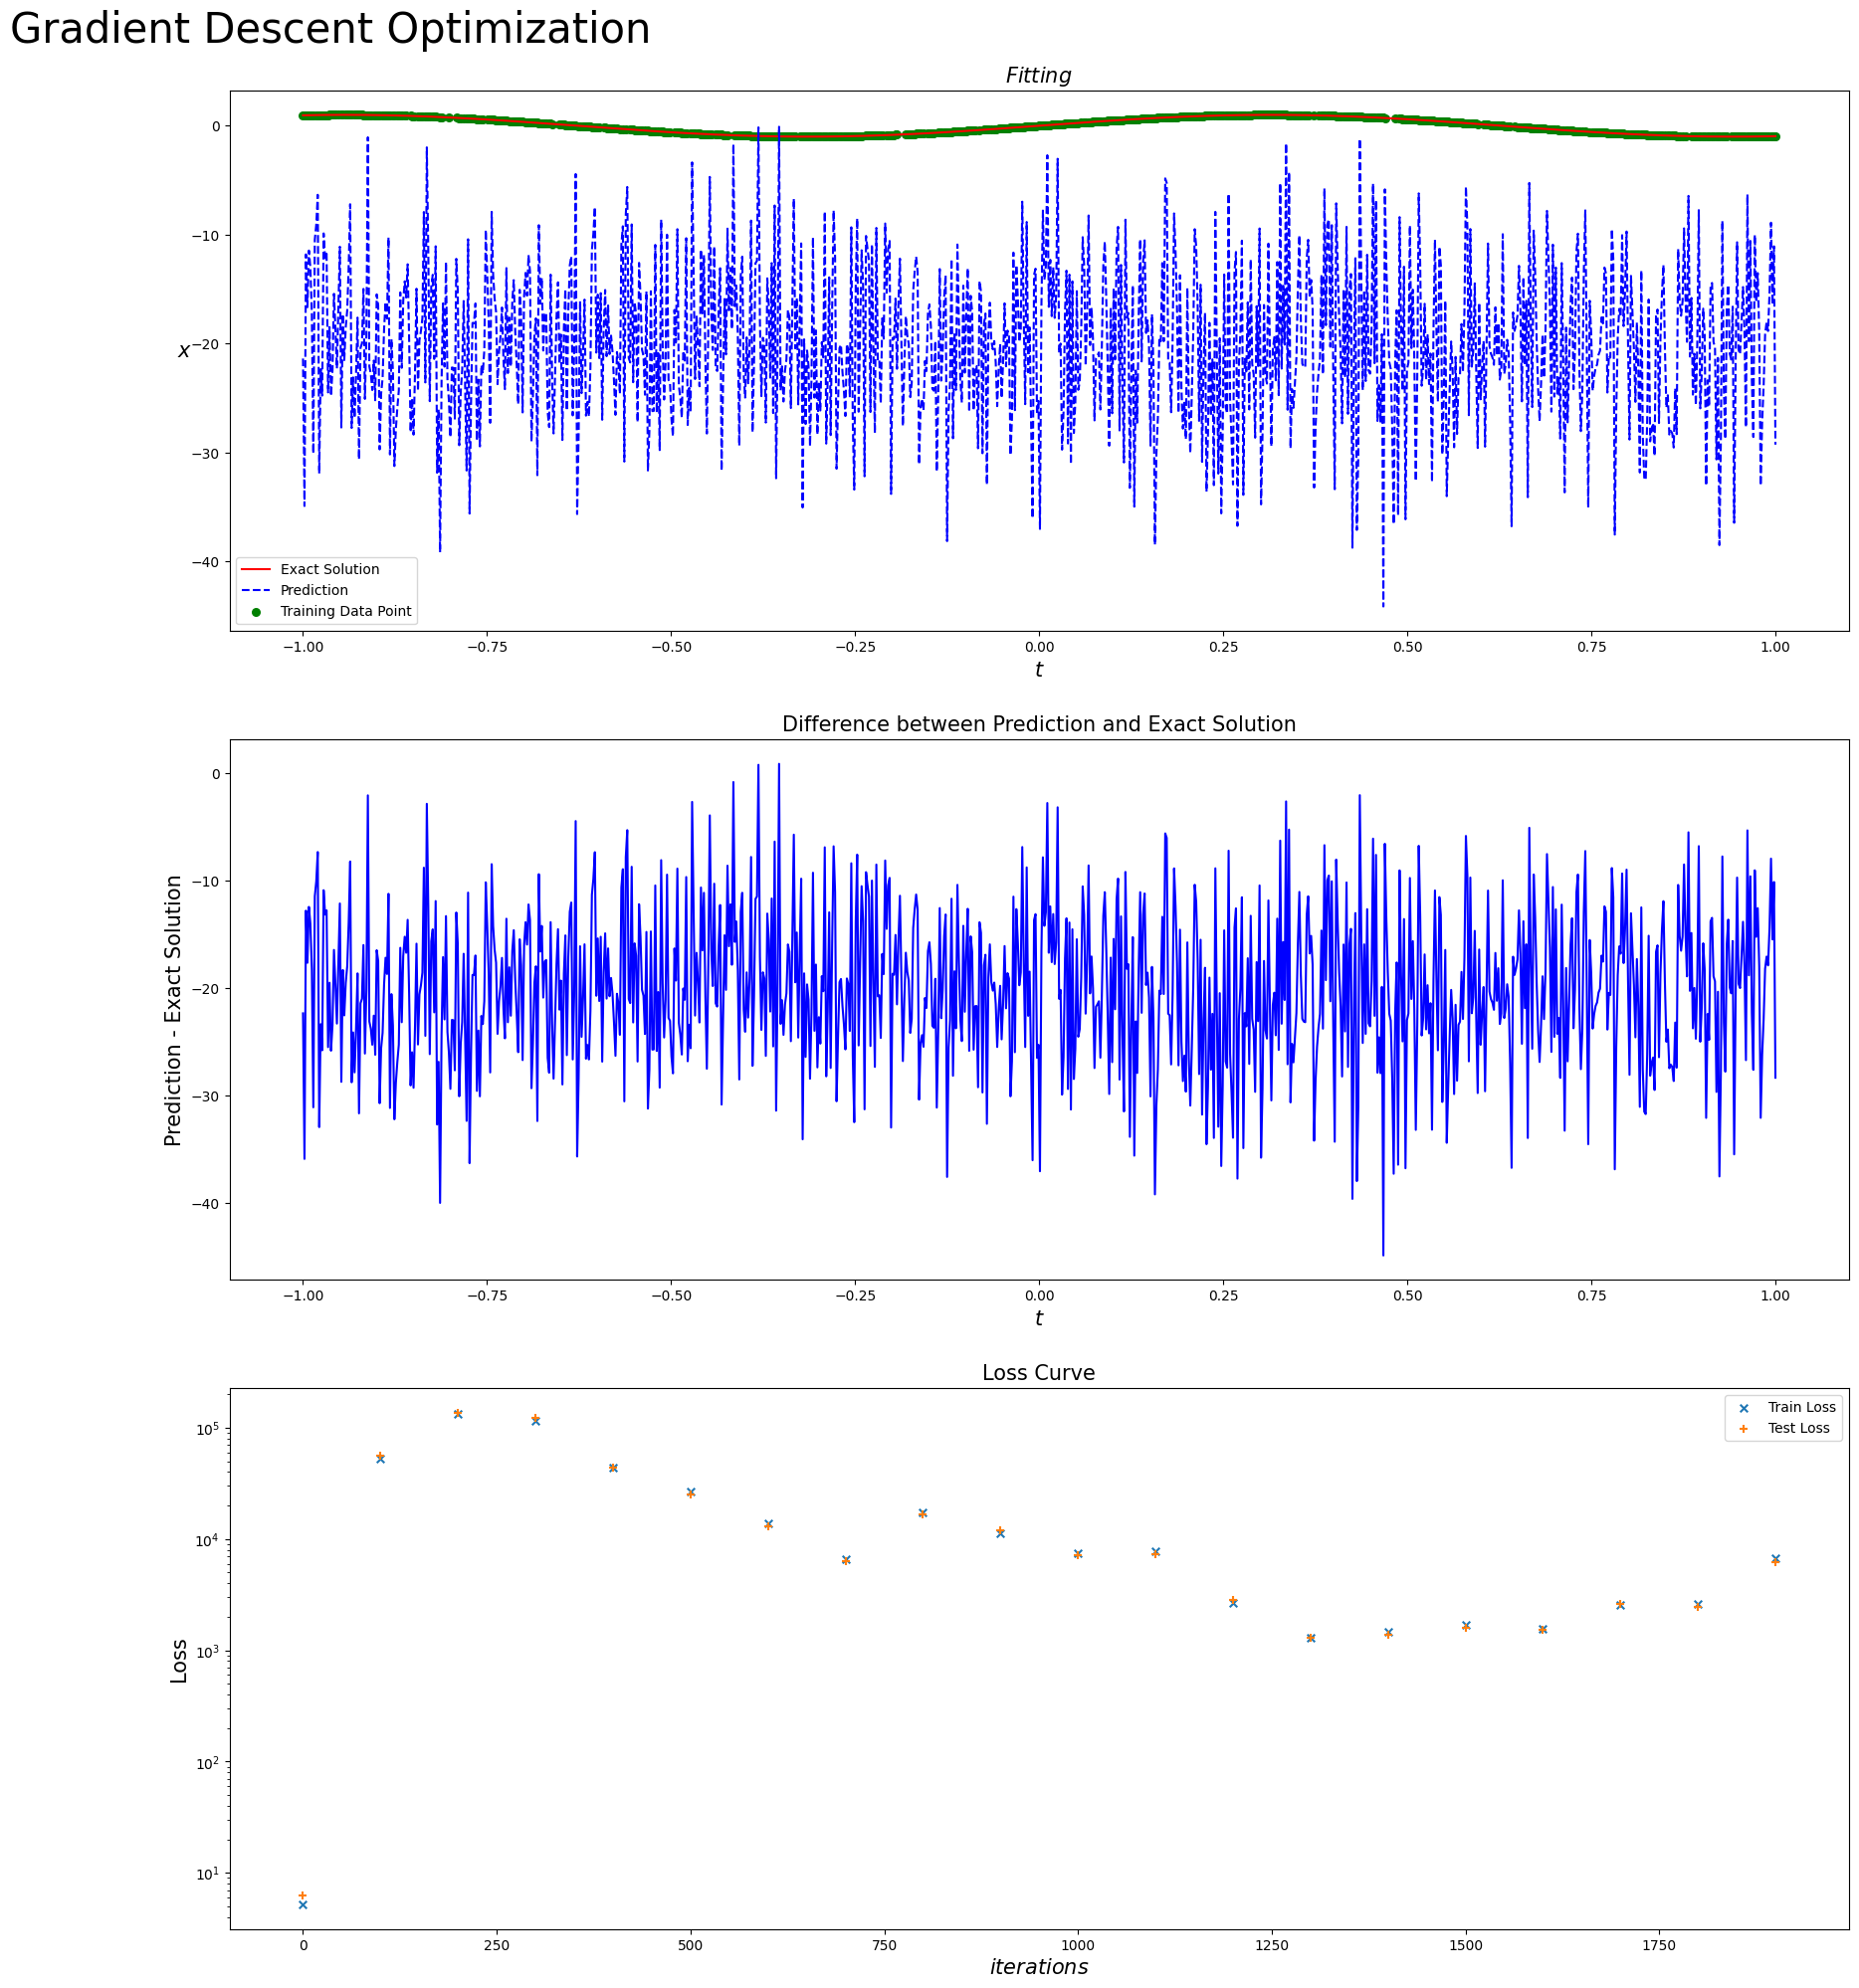

In [ ]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = x = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.1, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_train, x_train, title="Gradient Descent Optimization")

### Tasks
1. Find the learning rate that makes the loss converge
2. Find the minimum amount of training data needed to make the loss converge
3. Effects of activation function
4. Effects of noisy data (e.g. Gausian noise)
5. Find the parameters that can cause overfitting (test loss increases over iterations). The maximum iterations you can use is 20k.